# Identifying Fraud from Enron Email 

# 1. Setting Up Environment

In [1]:
#!/usr/bin/python
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from __future__ import division
from sklearn.metrics  import confusion_matrix 
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split   ##### Change to newer version
from sklearn import tree
from sklearn.metrics import accuracy_score
import sys
from time import time
import pickle
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option("display.precision", 3)
'''
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 0)
'''
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
import sys


C:\Users\leland\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 2. Understanding the Dataset

## 2.1 Data Exploration


### Bckground

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. 

### Data Structure
- Financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

- Email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

- POI label: [‘poi’] (boolean, represented as integer)

In [2]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [3]:
type(data_dict)

dict

In [4]:
len(data_dict.keys()) # number of observations

146

In [5]:
sorted(data_dict.keys()) # preview keys

['ALLEN PHILLIP K',
 'BADUM JAMES P',
 'BANNANTINE JAMES M',
 'BAXTER JOHN C',
 'BAY FRANKLIN R',
 'BAZELIDES PHILIP J',
 'BECK SALLY W',
 'BELDEN TIMOTHY N',
 'BELFER ROBERT',
 'BERBERIAN DAVID',
 'BERGSIEKER RICHARD P',
 'BHATNAGAR SANJAY',
 'BIBI PHILIPPE A',
 'BLACHMAN JEREMY M',
 'BLAKE JR. NORMAN P',
 'BOWEN JR RAYMOND M',
 'BROWN MICHAEL',
 'BUCHANAN HAROLD G',
 'BUTTS ROBERT H',
 'BUY RICHARD B',
 'CALGER CHRISTOPHER F',
 'CARTER REBECCA C',
 'CAUSEY RICHARD A',
 'CHAN RONNIE',
 'CHRISTODOULOU DIOMEDES',
 'CLINE KENNETH W',
 'COLWELL WESLEY',
 'CORDES WILLIAM R',
 'COX DAVID',
 'CUMBERLAND MICHAEL S',
 'DEFFNER JOSEPH M',
 'DELAINEY DAVID W',
 'DERRICK JR. JAMES V',
 'DETMERING TIMOTHY J',
 'DIETRICH JANET R',
 'DIMICHELE RICHARD G',
 'DODSON KEITH',
 'DONAHUE JR JEFFREY M',
 'DUNCAN JOHN H',
 'DURAN WILLIAM D',
 'ECHOLS JOHN B',
 'ELLIOTT STEVEN',
 'FALLON JAMES B',
 'FASTOW ANDREW S',
 'FITZGERALD JAY L',
 'FOWLER PEGGY',
 'FOY JOE',
 'FREVERT MARK A',
 'FUGH JOHN L',
 'GAHN 

In [6]:
data_dict['METTS MARK'].keys()  # features

['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 'email_address',
 'from_poi_to_this_person']

In [7]:
# people of interest
count=0
for key,item in data_dict.iteritems():
    if item['poi']:
        print key
        count +=1
count

HANNON KEVIN P
COLWELL WESLEY
RIEKER PAULA H
KOPPER MICHAEL J
SHELBY REX
DELAINEY DAVID W
LAY KENNETH L
BOWEN JR RAYMOND M
BELDEN TIMOTHY N
FASTOW ANDREW S
CALGER CHRISTOPHER F
RICE KENNETH D
SKILLING JEFFREY K
YEAGER F SCOTT
HIRKO JOSEPH
KOENIG MARK E
CAUSEY RICHARD A
GLISAN JR BEN F


18

In [8]:
# create a dictionary for all missing values
missing = {}
for key, item in data_dict.iteritems():
    for elem, value in item.iteritems():
        if value == "NaN":
            if elem not in missing:
                missing[elem] = 1
            else:
                missing[elem] += 1

In [9]:
# Missing values
missing = {}
for key, item in data_dict.iteritems():
    for elem, value in item.iteritems():
        if value == "NaN":
            if elem not in missing:
                missing[elem] = 1
            else:
                missing[elem] += 1
missing

{'bonus': 64,
 'deferral_payments': 107,
 'deferred_income': 97,
 'director_fees': 129,
 'email_address': 35,
 'exercised_stock_options': 44,
 'expenses': 51,
 'from_messages': 60,
 'from_poi_to_this_person': 60,
 'from_this_person_to_poi': 60,
 'loan_advances': 142,
 'long_term_incentive': 80,
 'other': 53,
 'restricted_stock': 36,
 'restricted_stock_deferred': 128,
 'salary': 51,
 'shared_receipt_with_poi': 60,
 'to_messages': 60,
 'total_payments': 21,
 'total_stock_value': 20}

In [10]:
# number of missing values
number_of_missing = 0
for key, item in missing.iteritems():
    number_of_missing += item
number_of_missing

1358

### Data Summary

- We have 146 people / data points in our dataset.
- There are 128 non-POIs and 18 POIs in our dataset.
- There are 21 available features.
- We have 1358 missing data points

The following features seems to lack data points:

- director_fees
- loan_advances
- deferral_payments
- deferred_income
- restricted_stock_deferred

We will later convert these NaNs to zeros through feature format.

## 2.2 Remove Outliers

Outliers could bias out model.First we will check whether some of data are outliers. Then we will see whether we should remove them or not. We have already know there is an outlier called 'total',which we will remove first.

In [11]:
# Remove 'Total'
data_dict.pop('TOTAL','not found')

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

### (1) Check for Outliers

First we take all features. We will do some summary statistics to all them to spot outliers.

In [12]:
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_to_test = ['poi',
                 'salary',
                 'to_messages',
                 'deferral_payments',
                 'total_payments',
                 'exercised_stock_options',
                 'bonus',
                 'restricted_stock',
                 'shared_receipt_with_poi',
                 'restricted_stock_deferred',
                 'total_stock_value',
                 'expenses',
                 'loan_advances',
                 'from_messages',
                 'other',
                 'from_this_person_to_poi',
                 'director_fees',
                 'deferred_income',
                 'long_term_incentive',
                 'from_poi_to_this_person']

# format the dataset
data_to_test = featureFormat(data_dict, features_to_test)

# create a pandas dataframe
df = pd.DataFrame(data_to_test, columns = features_to_test)

In [13]:
# an alternative way to convert to pd

# We will use pandas many times in our project so turn this into a function:
def to_pandas(data_dict):
    df = pd.DataFrame(data_dict)
    df = df.convert_objects(convert_numeric=True)
    df = df.transpose()
    df.reset_index(level=0, inplace=True)
    # Renaming with df.rename(columns={'index': 'name'}) does not work
    # pandas bug??
    columns = list(df.columns)
    columns[0] = 'name'
    df.columns = columns
    return(df)
df = to_pandas(data_dict)

C:\Users\leland\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [14]:
df.shape

(145, 22)

In [15]:
len(data_dict.keys())

145

In [16]:
type(data_to_test)

numpy.ndarray

In [17]:
data_to_test.shape

(144L, 20L)

In [18]:
df.shape

(145, 22)

In [19]:
des=df.describe() # Explore features
des.transpose()

,count,mean,std,min,25%,50%,75%,max
bonus,81.000,1201773.074,1441679.438,70000.000,425000.000,750000.000,1200000.000,8000000.000
deferral_payments,38.000,841602.526,1289322.626,-102500.000,79644.500,221063.500,867211.250,6426990.000
deferred_income,48.000,-581049.812,942076.403,-3504386.000,-611209.250,-151927.000,-37926.000,-833.000
director_fees,16.000,89822.875,41112.701,3285.000,83674.500,106164.500,112815.000,137864.000
email_address,0.000,nan,nan,nan,nan,nan,nan,nan
exercised_stock_options,101.000,2959559.257,5499449.599,3285.000,506765.000,1297049.000,2542813.000,34348384.000
expenses,94.000,54192.011,46108.377,148.000,22479.000,46547.500,78408.500,228763.000
from_messages,86.000,608.791,1841.034,12.000,22.750,41.000,145.500,14368.000
from_poi_to_this_person,86.000,64.895,86.979,0.000,10.000,35.000,72.250,528.000
from_this_person_to_poi,86.000,41.233,100.073,0.000,1.000,8.000,24.750,609.000


In [20]:
bypoi=df.groupby(['poi'])
bypoi['bonus',
    'salary',
    'exercised_stock_options',
    'shared_receipt_with_poi',
    'loan_advances',
    'to_messages'].agg([np.mean])

,bonus,salary,exercised_stock_options,shared_receipt_with_poi,loan_advances,to_messages
,mean,mean,mean,mean,mean,mean
poi,,,,,,
0.000,986824.923,262151.506,1947752.371,1058.528,1200000.000,2007.111
1.000,2074999.938,383444.882,10463793.667,1783.000,81525000.000,2417.143


 There is an outlier called "THE TRAVEL AGENCY IN THE PARK", which is not an employee. We will simply remove it.

In [21]:
# Remove 'Total'
data_dict.pop('THE TRAVEL AGENCY IN THE PARK','not found')

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}

###  (3) Visualize Outliers

We will plots histgrams to check each feature for outliers.

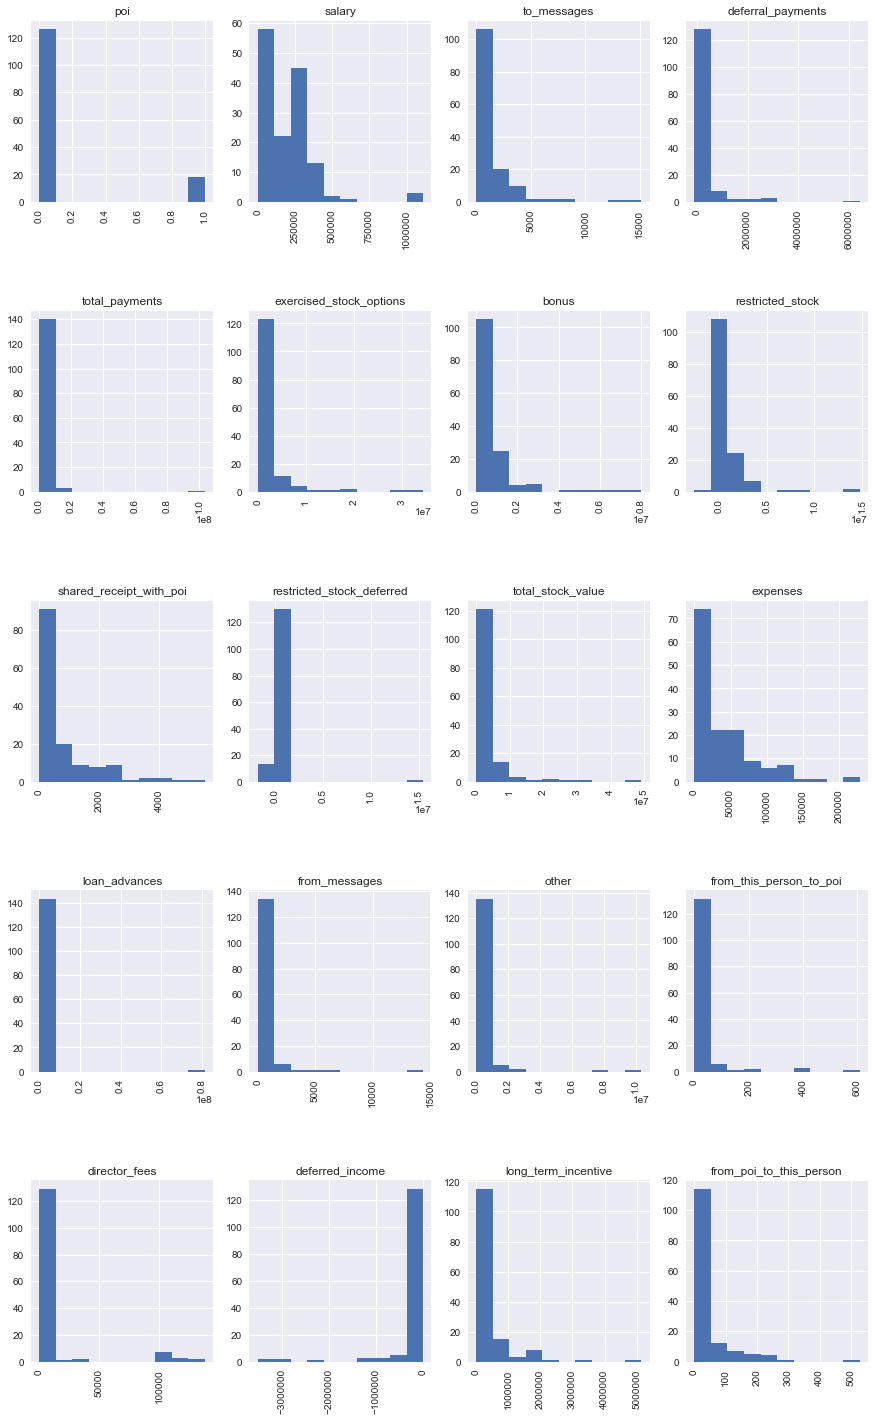

In [22]:
# This creates a canvas of size 15 points width and 30 points height
fig = plt.figure(figsize=(15, 30))

for idx, feature in enumerate(features_to_test):
    # This means: Divide that canvas to 6 rows, 3 columns,
    # and at idx+1 position (since subplot is base-1), draw our plot.
    ax = plt.subplot(6,4, idx+1)
    
    plt.title(feature)
    plt.xticks(rotation='vertical')
    
    # hspace here sets space between rows.
    # http://matplotlib.org/api/figure_api.html#matplotlib.figure.SubplotParams
    plt.subplots_adjust(hspace=.6) 
    
    ax.hist(data_to_test[:,idx])

As you can see from above histgrams, all of them are very skewed and have suspicious data. We will look at them case by case. The following features are very suspicous:

- Total payments: a few values are way bigger than the rest
- Loan advances: suspicoud large tails
- Restricted stock deferred: negative values occurred
- Total stock value

We will check them one by one later.

In [23]:
def show_largest_five(data_dict, features, feature):
    # What are the 5 largest points, sorted by x?
    print "5 largest", feature
    sorted_list = sorted(data_dict.iteritems(), 
                 key=lambda (key, val): int(0 if val[feature] == 'NaN' else val[feature]), reverse=True)[0:5]
    print [(i[0]+ "(" + ('poi' if i[1]['poi'] else 'not poi') + "): "+ str(i[1][feature])) for i in sorted_list]

In [24]:
for feature in features_to_test:
    show_largest_five(data_dict,features_to_test,feature)
    print

5 largest poi
['HANNON KEVIN P(poi): True', 'COLWELL WESLEY(poi): True', 'RIEKER PAULA H(poi): True', 'KOPPER MICHAEL J(poi): True', 'SHELBY REX(poi): True']

5 largest salary
['SKILLING JEFFREY K(poi): 1111258', 'LAY KENNETH L(poi): 1072321', 'FREVERT MARK A(not poi): 1060932', 'PICKERING MARK R(not poi): 655037', 'WHALLEY LAWRENCE G(not poi): 510364']

5 largest to_messages
['SHAPIRO RICHARD S(not poi): 15149', 'KEAN STEVEN J(not poi): 12754', 'KITCHEN LOUISE(not poi): 8305', 'BELDEN TIMOTHY N(poi): 7991', 'BECK SALLY W(not poi): 7315']

5 largest deferral_payments
['FREVERT MARK A(not poi): 6426990', 'HORTON STANLEY C(not poi): 3131860', 'HUMPHREY GENE E(not poi): 2964506', 'ALLEN PHILLIP K(not poi): 2869717', 'HAEDICKE MARK E(not poi): 2157527']

5 largest total_payments
['LAY KENNETH L(poi): 103559793', 'FREVERT MARK A(not poi): 17252530', 'BHATNAGAR SANJAY(not poi): 15456290', 'LAVORATO JOHN J(not poi): 10425757', 'SKILLING JEFFREY K(poi): 8682716']

5 largest exercised_stock_opt

For the largest 5 values in all the feature there are two types of pattern, either most ourliers are poi or not related with poi, which shows no suspicion for outlier. restricted_stock_deferred could be an outlier, but we can't really tell at the moment,because the largest value does not belong to

### (4) Cross reference with the insider pay PDF.

From the pdf, we can find that there are two groups of insider pays:

Total_payments, which is a combination of:
- salary
- bonus
- director_fees
- deferral_payments
- deferred_income
- loan_advances
- long_term_incentive
- expenses
- other
- salary

Total_stock_value, a combination of:
- restricted_stock
- exercised_stock_options
- restricted_stock_deferred

We will check if there is any input errors by sum them up and compare.

In [25]:
df2 = pd.DataFrame()

df = df.fillna(0)
df2['name'] = df['name']
df2['combined'] = (
    df['bonus'] + 
    df['director_fees'] +
    df['deferral_payments'] +
    df['deferred_income'] +
    df['loan_advances'] +
    df['long_term_incentive'] +
    df['expenses'] +
    df['other'] +
    df['salary']
)
df2['total_payments'] = df['total_payments']
df2['equals?'] = (df2['combined'] == df2['total_payments'])
df2['poi'] = df['poi']
print df2.head(5)
print np.sum(df2['equals?']), " out of ", len(df2)
print "Total difference between combined and total_payments: ", (np.sum(df2['total_payments']) - np.sum(df2['combined']))
print "\n"
print "Which data points are different?"
print df2[df2['equals?'] == False]
df[df['name'].isin(df2[df2['equals?'] == False]['name'].tolist())]

                 name    combined  total_payments equals?   poi
0     ALLEN PHILLIP K 4484442.000     4484442.000    True 0.000
1       BADUM JAMES P  182466.000      182466.000    True 0.000
2  BANNANTINE JAMES M  916197.000      916197.000    True 0.000
3       BAXTER JOHN C 5634343.000     5634343.000    True 0.000
4      BAY FRANKLIN R  827696.000      827696.000    True 0.000
143  out of  145
Total difference between combined and total_payments:  15382277.0


Which data points are different?
                name   combined  total_payments equals?   poi
8      BELFER ROBERT -99215.000      102500.000   False 0.000
11  BHATNAGAR SANJAY 275728.000    15456290.000   False 0.000


,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
8,BELFER ROBERT,0.000,-102500.000,0.000,3285.000,0.000,3285.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,44093.000,0.000,0.000,0.000,102500.000,-44093.000
11,BHATNAGAR SANJAY,0.000,0.000,0.000,137864.000,0.000,2604490.000,0.000,29.000,0.000,...,0.000,137864.000,0.000,-2604490.000,15456290.000,0.000,463.000,523.000,15456290.000,0.000


In [26]:
# dataframe to check total_stock_value
df3 = pd.DataFrame()

df = df.fillna(0)
df3['name'] = df['name']
df3['combined'] = (
    df['restricted_stock'] +
    df['exercised_stock_options'] +
    df['restricted_stock_deferred']
)
df3['total_stock_value'] = df['total_stock_value']
df3['equals?'] = (df3['combined'] == df3['total_stock_value'])
df3['poi'] = df['poi']
print df3.head(5)
print np.sum(df3['equals?']), " out of ", len(df3)
print "Total difference between combined and total_stock_value: ", (np.sum(df3['total_stock_value']) - np.sum(df3['combined']))
print "\n"
print "Which data points are different?"
print df3[df3['equals?'] == False]
df[df['name'].isin(df3[df3['equals?'] == False]['name'].tolist())]

                 name     combined  total_stock_value equals?   poi
0     ALLEN PHILLIP K  1729541.000        1729541.000    True 0.000
1       BADUM JAMES P   257817.000         257817.000    True 0.000
2  BANNANTINE JAMES M  5243487.000        5243487.000    True 0.000
3       BAXTER JOHN C 10623258.000       10623258.000    True 0.000
4      BAY FRANKLIN R    63014.000          63014.000    True 0.000
143  out of  145
Total difference between combined and total_stock_value:  -15547761.0


Which data points are different?
                name     combined  total_stock_value equals?   poi
8      BELFER ROBERT    47378.000         -44093.000   False 0.000
11  BHATNAGAR SANJAY 15456290.000              0.000   False 0.000


,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
8,BELFER ROBERT,0.000,-102500.000,0.000,3285.000,0.000,3285.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,44093.000,0.000,0.000,0.000,102500.000,-44093.000
11,BHATNAGAR SANJAY,0.000,0.000,0.000,137864.000,0.000,2604490.000,0.000,29.000,0.000,...,0.000,137864.000,0.000,-2604490.000,15456290.000,0.000,463.000,523.000,15456290.000,0.000


We will update the two persons data below. It looks lkie a typo in the data.

In [27]:
data_dict_updated = data_dict
data_dict_updated['BELFER ROBERT']['deferred_income'] = -102500
data_dict_updated['BELFER ROBERT']['deferral_payments'] = 'NaN'
data_dict_updated['BELFER ROBERT']['expenses'] = 3285
data_dict_updated['BELFER ROBERT']['director_fees'] = 102500
data_dict_updated['BELFER ROBERT']['total_payments'] = 3285
data_dict_updated['BELFER ROBERT']['exercised_stock_options'] = 'NaN'
data_dict_updated['BELFER ROBERT']['restricted_stock'] = 44093
data_dict_updated['BELFER ROBERT']['restricted_stock_deferred'] = -44093
data_dict_updated['BELFER ROBERT']['total_stock_value'] = 'NaN'

data_dict_updated['BHATNAGAR SANJAY']['other'] = 'NaN'
data_dict_updated['BHATNAGAR SANJAY']['expenses'] = 137864
data_dict_updated['BHATNAGAR SANJAY']['director_fees'] = 'NaN'
data_dict_updated['BHATNAGAR SANJAY']['total_payments'] = 137864
data_dict_updated['BHATNAGAR SANJAY']['exercised_stock_options'] = 15456290
data_dict_updated['BHATNAGAR SANJAY']['restricted_stock'] = 2604490
data_dict_updated['BHATNAGAR SANJAY']['restricted_stock_deferred'] = -2604490
data_dict_updated['BHATNAGAR SANJAY']['total_stock_value'] = 15456290

###   Create My Data

In [28]:
my_dataset = data_dict_updated

# 3. Optimize Feature Selection/Engineering



## 3.1 Create new features


We will create two new features that could help us identify potential poi.

1. poi_from_ratio( from_this_person_to_poi_ratio):Messages sent from this person to pois compared to all messages sent by this person
2. poi_to_ratio(from_poi_to_this_person_ratio): Messages received by this person from pois compared to all messages received by this person.

In [29]:
#create new features
for key, item in my_dataset.iteritems():
   
    ### add poi_from_ratio
    if item['from_messages'] != "NaN" and item['from_poi_to_this_person'] != "NaN":
        item['poi_from_ratio'] = float(item['from_poi_to_this_person']) / item['from_messages']
    else:
        item['poi_from_ratio'] = "NaN"
        
    ### add poi_to_ratio
    if item["to_messages"] != "NaN" and item["from_this_person_to_poi"] != "NaN":
        item["poi_to_ratio"] = float(item["from_this_person_to_poi"]) / item["to_messages"]
    else:
        item["poi_to_ratio"] = "NaN"

In [30]:
# summary statistics for new features

df_newfeature=to_pandas(my_dataset)
print('poi_from_ratio')
print( df_newfeature['poi_from_ratio'].describe())
print
print('poi_to_ratio')
print( df_newfeature['poi_to_ratio'].describe())

poi_from_ratio
count   86.000
mean     1.108
std      2.026
min      0.000
25%      0.046
50%      0.385
75%      1.154
max     11.524
Name: poi_from_ratio, dtype: float64

poi_to_ratio
count   86.000
mean     0.017
std      0.031
min      0.000
25%      0.001
50%      0.006
75%      0.020
max      0.197
Name: poi_to_ratio, dtype: float64


C:\Users\leland\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


As we can see, there are 86 people who have email communications with our poi, which could be an indicator of possible poi

In [31]:
# Add new features to feature list test
features_to_test +=["poi_from_ratio", "poi_to_ratio"]

## 3.2 Scale Features

We will first scale the feature before we do the features selections. The scale might affect the feature selection methods so it is necessary to scale first.

In [32]:
features_list=features_to_test
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [33]:
# scale features
from sklearn.preprocessing import scale
features = scale(features)

 ## 3.3 Select Features 
 
 We will first examine the relationship among variables and then use feature selection methods.

### Correlations

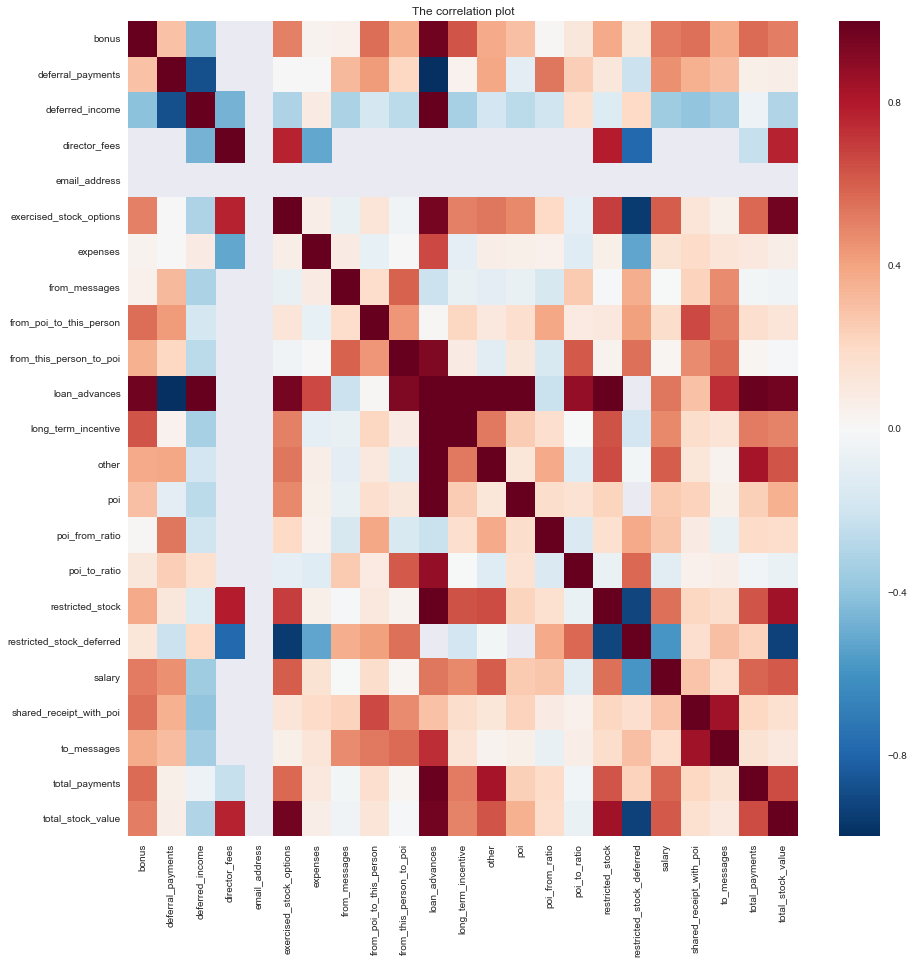

In [34]:
# correlation
fig = plt.figure(figsize=(15, 15))

corr=df_newfeature.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)   # Similar:plt.matshow(dt.corr())

plt.title('The correlation plot')

- email_address : It looks like it is unrelated to almost all other features. We decided to remove it.
- stock_salary_ratio: It has weak relationship with other variables (including poi) too, so we will remove it. 

### Kbest

In [35]:
from sklearn.feature_selection import SelectKBest
k_best = SelectKBest(k = 7)
k_best_features = k_best.fit_transform(features, labels)

In [36]:
k_best_result = zip(features_list[1:], k_best.scores_, k_best.get_support())
k_best_result.sort(key=lambda value:value[1], reverse=True)

In [37]:
k_best_result

[('total_stock_value', 22.510549090242062, True),
 ('exercised_stock_options', 22.348975407306224, True),
 ('bonus', 20.792252047181535, True),
 ('salary', 18.289684043404495, True),
 ('deferred_income', 11.424891485418353, True),
 ('long_term_incentive', 9.9221860131898119, True),
 ('total_payments', 9.2838736184273731, True),
 ('restricted_stock', 8.8254422199164662, False),
 ('shared_receipt_with_poi', 8.5894207316823685, False),
 ('loan_advances', 7.1840556582887265, False),
 ('expenses', 5.4189001894070339, False),
 ('from_poi_to_this_person', 5.243449713374944, False),
 ('poi_from_ratio', 5.1239461527568961, False),
 ('other', 4.2024363002712297, False),
 ('poi_to_ratio', 4.0946533095769562, False),
 ('from_this_person_to_poi', 2.382612108227677, False),
 ('director_fees', 2.131483992461205, False),
 ('to_messages', 1.6463411294420078, False),
 ('restricted_stock_deferred', 0.76814634478713084, False),
 ('deferral_payments', 0.22885961902145854, False),
 ('from_messages', 0.16970

### Linear

In [38]:
from sklearn.svm import LinearSVC
svc = LinearSVC(penalty="l1", dual=False, random_state=31)
svc_features = svc.fit_transform(features, labels)

C:\Users\leland\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


In [39]:
svc_result = zip(features_list[1:], svc.coef_[0])
svc_result.sort(key=lambda value:value[1], reverse=True)

In [40]:
print(svc_features.shape)
svc_result

(143L, 15L)


[('from_this_person_to_poi', 0.34922456010185954),
 ('exercised_stock_options', 0.24666814961570338),
 ('restricted_stock_deferred', 0.22758636485092776),
 ('shared_receipt_with_poi', 0.21752929822528697),
 ('salary', 0.13771530317856642),
 ('poi_to_ratio', 0.1101750768240648),
 ('expenses', 0.088938286840805514),
 ('poi_from_ratio', 0.080378416019982468),
 ('total_payments', 0.0),
 ('restricted_stock', 0.0),
 ('total_stock_value', 0.0),
 ('loan_advances', 0.0),
 ('director_fees', 0.0),
 ('from_poi_to_this_person', 0.0),
 ('other', -0.023571168057028531),
 ('bonus', -0.047621998743623356),
 ('long_term_incentive', -0.075600360613638631),
 ('to_messages', -0.084276570412668492),
 ('deferral_payments', -0.59166506213251135),
 ('deferred_income', -0.60013019012160695),
 ('from_messages', -1.0360609112678858)]

### Randomized Logistic Regression

In [41]:
from sklearn.linear_model import RandomizedLogisticRegression
randomized_logistic = RandomizedLogisticRegression(C=1, selection_threshold=0.01, random_state=31)
randomized_features = randomized_logistic.fit_transform(features, labels)
randomized_result = zip(features_list[1:], randomized_logistic.scores_, randomized_logistic.get_support())
randomized_result.sort(key=lambda value:value[1], reverse=True)

In [42]:
print(randomized_features.shape)
randomized_result

(143L, 5L)


[('exercised_stock_options', 0.27500000000000002, True),
 ('bonus', 0.255, True),
 ('total_stock_value', 0.19500000000000001, True),
 ('salary', 0.155, True),
 ('deferred_income', 0.125, True),
 ('shared_receipt_with_poi', 0.01, False),
 ('total_payments', 0.0050000000000000001, False),
 ('long_term_incentive', 0.0050000000000000001, False),
 ('to_messages', 0.0, False),
 ('deferral_payments', 0.0, False),
 ('restricted_stock', 0.0, False),
 ('restricted_stock_deferred', 0.0, False),
 ('expenses', 0.0, False),
 ('loan_advances', 0.0, False),
 ('from_messages', 0.0, False),
 ('other', 0.0, False),
 ('from_this_person_to_poi', 0.0, False),
 ('director_fees', 0.0, False),
 ('from_poi_to_this_person', 0.0, False),
 ('poi_from_ratio', 0.0, False),
 ('poi_to_ratio', 0.0, False)]

### Extra Tree Classifier


In [43]:
from sklearn.ensemble import ExtraTreesClassifier
tree = ExtraTreesClassifier(max_features=5, random_state=31)
tree_features = tree.fit_transform(features, labels)
tree_result = zip(features_list[1:], tree.feature_importances_)
tree_result.sort(key=lambda value: value[1], reverse=True)

C:\Users\leland\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


In [44]:
print(tree_features.shape)
tree_result

(143L, 9L)


[('exercised_stock_options', 0.09926509112426482),
 ('total_stock_value', 0.086209354218185458),
 ('salary', 0.084276813907338419),
 ('restricted_stock', 0.084251679125490392),
 ('bonus', 0.071663452637353381),
 ('deferred_income', 0.064385019884511771),
 ('shared_receipt_with_poi', 0.063612497256099784),
 ('poi_from_ratio', 0.06010921747455561),
 ('other', 0.047810184146652043),
 ('from_poi_to_this_person', 0.047273922567663128),
 ('to_messages', 0.045646104914421268),
 ('long_term_incentive', 0.041958962602810783),
 ('from_this_person_to_poi', 0.041046578809189951),
 ('expenses', 0.040900955127109076),
 ('total_payments', 0.037838460888789532),
 ('from_messages', 0.032430155954519556),
 ('poi_to_ratio', 0.02992961300196028),
 ('deferral_payments', 0.014649303350970025),
 ('restricted_stock_deferred', 0.0063616961889425656),
 ('director_fees', 0.00038093681917212099),
 ('loan_advances', 0.0)]

### PCA

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca_features = pca.fit_transform(features, labels)
pca_result = pca.explained_variance_ratio_

In [46]:
pca_result

array([ 0.31103997,  0.16426573,  0.08671483,  0.06394905,  0.0562138 ])

### Summary of feature selections

We will summarize the top features kept by above methods

- **Kbest**: exercised_stock_options,total_stock_value, bonus,salary,deferred_income, long_term_incentive, total_payments
- **SVC** : exercised_stock_options, poi_to_ratio,poi_from_ratio,bonus, expenses, shared_receipt_with_poi, salary, to_messages, from_messages, deferred_income, deferral_payments.
- **randomized_result**: exercised_stock_options, bonus, total_stock_value, salary,deferred_income
- **tree_result**: We could keep 9 features

## 3.4 Final features and data for Models

In [47]:
features_list = ['poi',
                 'salary',
                 'deferral_payments',
                 'total_payments',
                 'exercised_stock_options',
                 'bonus',
                 'restricted_stock',
                 'shared_receipt_with_poi',
                 'restricted_stock_deferred',
                 'total_stock_value',
                 'expenses',
                 'loan_advances',
                 'deferred_income',
                 'long_term_incentive',
                 ]
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [48]:
# scale the final data
features = scale(features)

In [49]:
# Split data into train and test
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

# 4. Pick and Tune an Algorithm



## 4.1 Different Algorithms 

### Algorithms
We will try following algorithms.
- Decision Trees
- Naive Bayes
- SVM
- Ensemble Classifers: Random Forest 

### Parameter Tuning and Importacnce

- Different algorithms deal with different data. Some algorithms are better than others depending on the data.
- The tuning of parameters deal with different assumptions on the data. Even though you are using the same type of algorithm, you might try different setting to optimize the behavior of your data.
- Different tuning paramters also have differnt characteristics such as speed or sensitivety. Depending on your data size or other aspects, you might adopt different settings.

### Setting up modules

In [50]:
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn import svm


## 4.2 Tuning Algorithms

### Naive Bayes

In [54]:
### try Naive Bayes for prediction
t0 = time()
nb_clf = GaussianNB()
nb_clf.fit(features_train, labels_train)
nb_pred = nb_clf.predict(features_test)
nb_accuracy = accuracy_score(labels_test,nb_pred)
print(nb_accuracy)

print("NB algorithm time:", round(time()-t0, 3), "s")

0.883720930233
('NB algorithm time:', 0.001, 's')


In [55]:
recall_score(labels_test,nb_pred)

0.59999999999999998

In [56]:
precision_score(labels_test,nb_pred)

0.5

### Decision Tree

In [57]:
t0 = time()
tree_clf=tree.DecisionTreeClassifier()
tree_clf.fit(features_train,labels_train)
tree_pred=tree_clf.predict(features_test)
accuracy=accuracy_score(labels_test,tree_pred)
print accuracy

print "Decition Tree algorithm time:", round(time()-t0, 3), "s"

0.790697674419
Decition Tree algorithm time: 0.001 s


In [58]:
print('Recall:', recall_score(labels_test,tree_pred))
print('Precision:', precision_score(labels_test,tree_pred))

('Recall:', 0.0)
('Precision:', 0.0)


### Tuning Using GridSearchCV 

In [61]:
t0 = time()

parameters_tree = {'max_depth':range(3,20),'criterion':('gini','entropy'),'min_samples_split':range(2,20)}
tree_clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters_tree)
tree_clf.fit(features_train,labels_train)
tree_model=tree_clf.best_estimator_
tree_pred=tree_model.predict(features_test)
tree_accuracy=accuracy_score(labels_test,tree_pred)
print "Decition Tree algorithm time:", round(time()-t0, 3), "s"

Decition Tree algorithm time: 3.92 s


In [63]:
print (tree_clf.best_score_, tree_clf.best_params_) 
print('Accuracy:', tree_accuracy)
print('Recall:', recall_score(labels_test,tree_pred))
print('Precision:', precision_score(labels_test,tree_pred))

(0.83999999999999997, {'min_samples_split': 5, 'criterion': 'entropy', 'max_depth': 3})
('Accuracy:', 0.83720930232558144)
('Recall:', 0.20000000000000001)
('Precision:', 0.25)


The tree method is not better than the Naive Bayes.

### SVM

In [64]:
t0=time()
svm_clf=svm.SVC()
svm_clf.fit(features_train,labels_train)
svm_pred=svm_clf.predict(features_test)

accuracy=accuracy_score(labels_test,svm_pred)
print accuracy

print "SVM algorithm time:", round(time()-t0, 3), "s"

0.883720930233
SVM algorithm time: 0.002 s


In [67]:
print('Recall:', recall_score(labels_test,svm_pred))
print('Precision:', precision_score(labels_test,svm_pred))

('Recall:', 0.0)
('Precision:', 0.0)


### Tuning Using GridSearchCV 

In [68]:
t0=time()
parameters_svm = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[1, 20]}
svm_clf=GridSearchCV(svm.SVC(),parameters_svm)
svm_clf.fit(features_train,labels_train)
svm_model=svm_clf.best_estimator_
svm_pred=svm_model.predict(features_test)
accuracy=accuracy_score(labels_test,svm_pred)
print "SVM algorithm time:", round(time()-t0, 3), "s"

SVM algorithm time: 0.089 s


In [69]:
print (svm_clf.best_score_, svm_clf.best_params_) 
print('Accuracy', accuracy)
print('Recall:', recall_score(labels_test,svm_pred))
print('Precision:', precision_score(labels_test,svm_pred))

(0.88, {'kernel': 'sigmoid', 'C': 1})
('Accuracy', 0.86046511627906974)
('Recall:', 0.0)
('Precision:', 0.0)


### Random Forest 

In [76]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
clf.fit(features_train,labels_train)
pred=clf.predict(features_test)
acc=accuracy_score(labels_test,pred)
acc


0.90697674418604646

In [77]:
recall_score(labels_test,pred)

0.20000000000000001

In [78]:
precision_score(labels_test,pred)

1.0

### Tuning Using GridSearchCV 

In [80]:
t0 = time()

parameters_tree = {'max_depth':range(3,20),'criterion':('gini','entropy'),\
                   'min_samples_split':range(2,20),'n_estimators':range(10,30)}

rf=RandomForestClassifier()

rf_clf = GridSearchCV(rf, parameters_tree)
rf_clf.fit(features_train,labels_train)
rf_model=tree_clf.best_estimator_
rf_pred=rf_model.predict(features_test)
rf_accuracy=accuracy_score(labels_test,rf_pred)
print "Ramdon Forest algorithm time:", round(time()-t0, 3), "s"

KeyboardInterrupt: 

In [ ]:
print (rf_clf.best_score_, rf_clf.best_params_) 
print('Accuracy:', rf_accuracy)
print('Recall:', recall_score(labels_test,rf_pred))
print('Precision:', precision_score(labels_test,rf_pred))

## 4.2 Algorithm Output

# 5. Validate and Evaluate

In [ ]:



### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
clf = GaussianNB()

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html



# Reference

[1. Fraud-detection-enron](https://github.com/yyforyongyu/fraud-detection-enron/blob/master/main/poi_id.ipynb)

[2. Udacity](https://classroom.udacity.com/nanodegrees/nd002/parts/0021345409/modules/317428862475461/lessons/3174288624239847/concepts/31803986370923)

[3. Identify Enron Data](https://jaycode.github.io/enron/identifying-fraud-from-enron-email.html)

[4. Identifying Fraud from Enron Email](http://cyuancheng.github.io/Intro-Machine-Learning/)

[5 Intro ML](https://github.com/cyuancheng/Intro-Machine-Learning/blob/master/Project4_ML_workflow.ipynb)

[6.Enron](https://github.com/DariaAlekseeva/Enron_Dataset/blob/master/Enron%20POI%20Detector%20Project%20Assignment.ipynb)